<a href="https://colab.research.google.com/github/viriditass/TIL/blob/main/U_Net_Convolutional_Networks_for_Biomedical_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **U-Net: Convolutional Networks for Biomedical Image Segmentation**

논문 링크: https://arxiv.org/abs/1505.04597

데이터셋: http://brainiac2.mit.edu/isbi_challenge/home
1. Register를 눌러 회원가입을 한다.
2. My account를 눌러 로그인을 한다.
3. Downloads를 눌러 아래의 이름으로 된 파일들을 다운받는다.
- ```train-volume.tif (7.5 MB)```
- ```train-labels.tif (7.5 MB)```
- ```test-volume.tif```

U-Net은 주로 **Biomedical** 분야에서 Classfication + Localization으로 활용된다. 이 네트워크는 Image Segmentation을 목적으로 제안된 End-to-End 방식의 **FCN(Fully-Convolutional Network)** 기반 모델이다.

## **U-Net 구조**

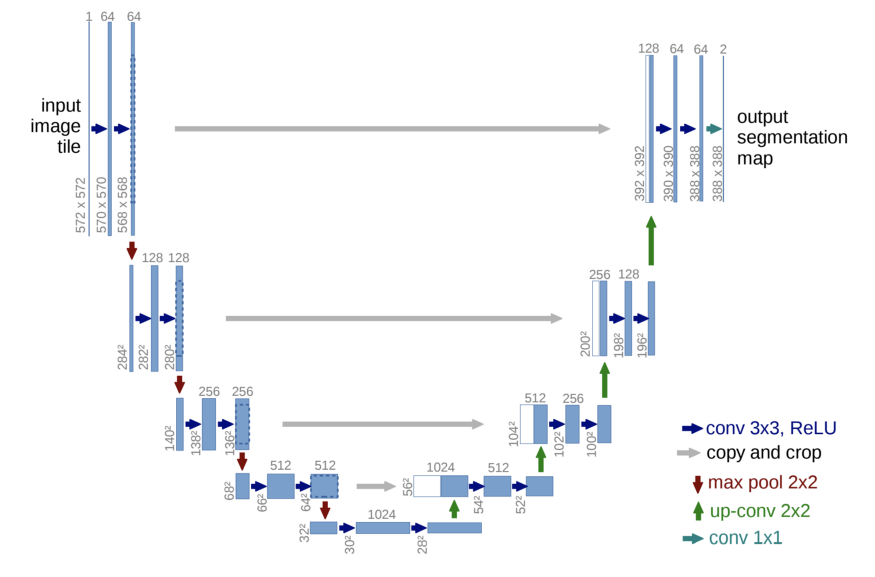

U-Net의 형태는 이름대로 알파벳 'U'와 비슷하게 생겼다. 전반적인 구조는 **Contracting Path (수축 단계)** 와 **Expanding Path (팽창 단계)**로 이루어져 있다. 또한, **Fully Connected Layer**가 없기 때문에 속도측면에서 빠르다.

U-Net의 특이한 점은 바로 U-Net을 가로지르는 회색 선이다. 이 선은 input이 output에 영향을 끼치도록 만든 선인데, **mirror padding**을 진행할때 손실되는 path를 살리기 위하여 contracting path의 데이터를 적당한 크기로 **Crop and Crop**을 사용하여 **Upsampling에 concat**으로 이미지 보상처리를 했다.

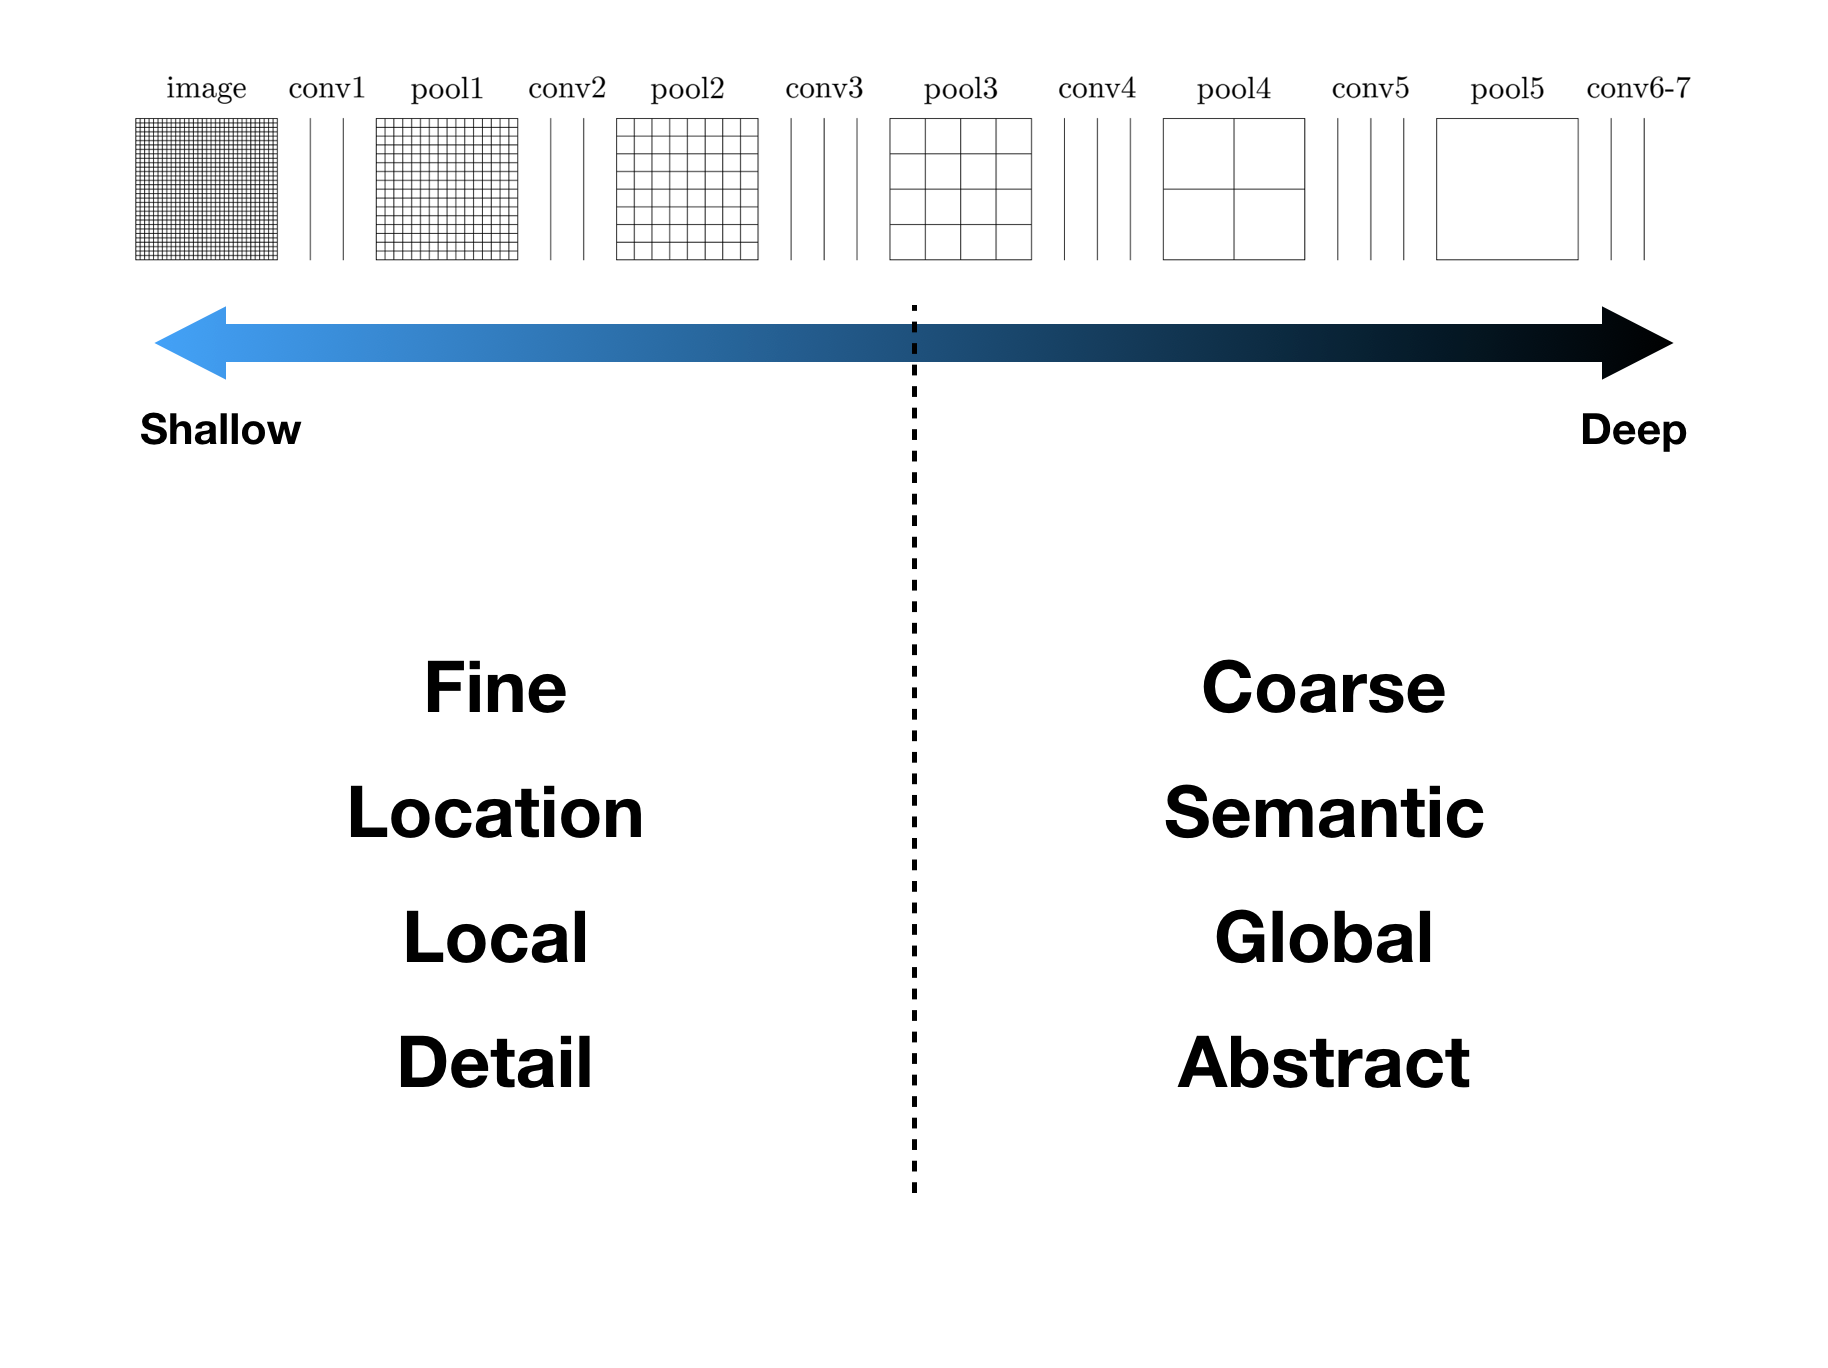

또한, U-Net은 **Coarse Map to Dense Map** 개념 뿐만아니라 **FCN의 Skip Architecture** 개념도 활용하여 얕은 층의 feature map을 깊은 층의 feature map과 결합하는 방식을 제안하였다.

### **Contracting Path & Expanding Path**

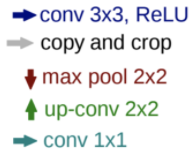

위 화살표가 어떤 역할을 하는지 살펴보고 이제 본격인 네트워크 구성(Architecture Detail)을 자세히 보겠다.

#### **Contracting Path**

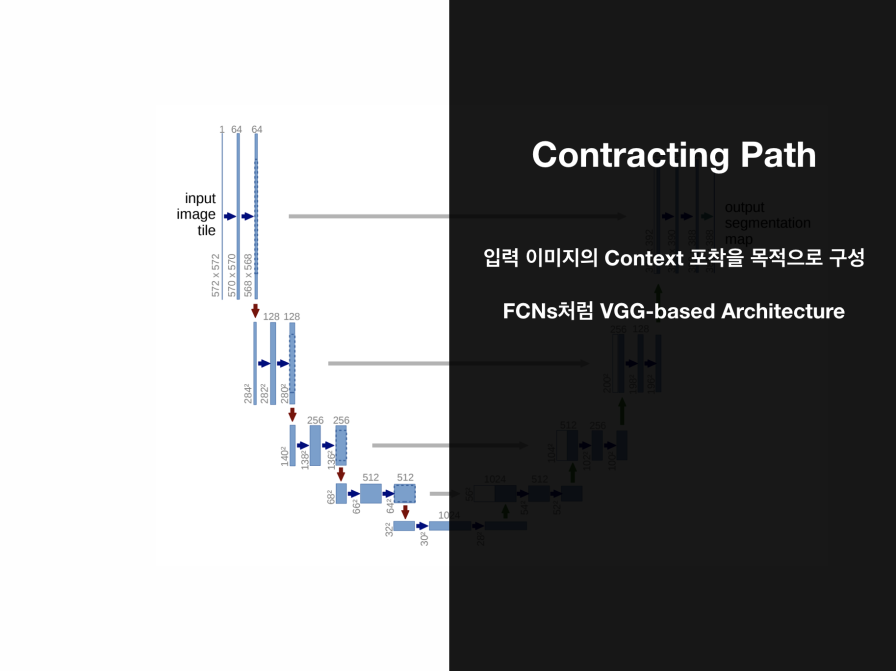

- 3x3 convolutions를 두 차례씩 반복 (padding이 없으므로 feature map이 조금씩 줄어듬)
- Activation function은 ReLU
- 2x2 max-pooling (stride=2)
- Down-sampling마다 채널의 수를 2배로 늘림

#### **Expanding Path**

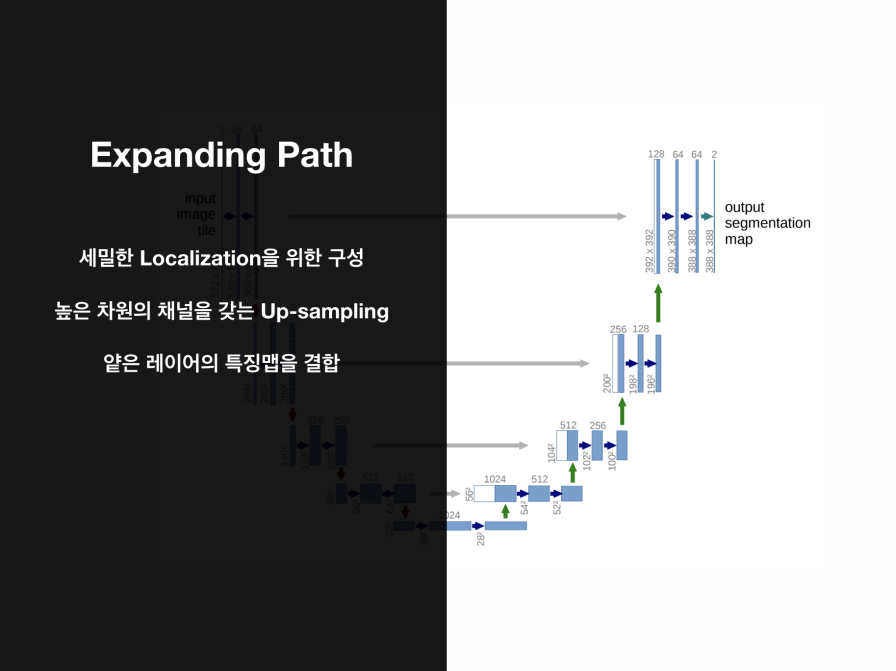

- 2x2 convolution (up-convolution)
- 3x3 convolutions를 두 차례씩 반복 (padding 없음)
- Up-Conv를 통한 Up-sampling마다 채널으 수를 반으로 줄임
- Activation function은 ReLU
- Up-Conv된 feature map을 Contrating path에서 Cropped된 feature map과 concatenation함
- 마지막 Layer에 1x1 convolution

이처럼 U-Net은 총 23 Layers-Fully-Convolutional-Networks 구조이다.

In [1]:
import os
import numpy as np

import torch
import torch.nn as nn

## UNet
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Convolution, Batch_normalization, ReLU
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path (encoder)
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64) # , kernel_size=3, stride=1, padding=1, bias=True
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)
        
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)
        
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)
        
        # Expansive path (decoder)
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)
        
        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, 
                                        kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, 
                                        kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, 
                                        kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                        kernel_size=2, stride=2, padding=0, bias=True)
                                        
        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels= 64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)
        
        # output map channel을 2개 + nn.CrossEntropyLoss == output map channel을 1개 + nn.BCELoss(binary cross entropy loss)
        # self.fc = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1, stride=1, padding=0, bias=True)
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
        
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)
        

        dec5_1 = self.dec5_1(enc5_1)
        
        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        # concatenation, dim=[0: batch, 1: channel, 2: height, 3: width]
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

위 코드를 보면 알 수 있듯이 Convolution, Batch_normalization, ReLU를 Sequential로 묶어 CBR2d 함수 형태로 만들었다, 그리고 forward를 보면 Expansive path 파트에 torch.cat을 이용하여 Concatenate를 해서 적용을 시켰다.

### **Optimizer**

Optimizer의 경우 **SGD(stochastic gradient descent)**를 사용했고, batch_size를 크게하여 학습시키는 것보다 input Tile(Patch)의 size를 크게 주는 방법을 선택하였다.

이유는 앞서 말했듯이 너무 작게 자를시 image의 Context의 의미가 없어지기 때문이다.

대신 **batch_size가 작기 때문에, 이를 보완하고자 momentum의 값을 0.99로 주어서 과거의 값들을 더욱 많이 반영하게 하여 학습을 진행**하였다.

### **Loss Function**

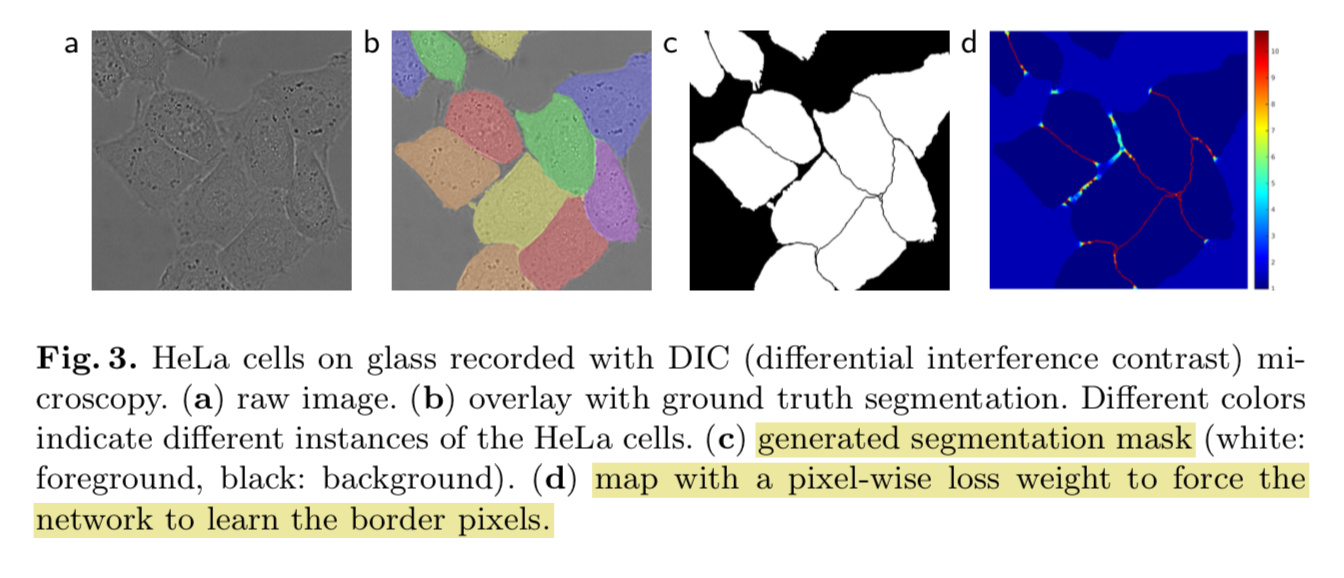

Biomedical Image의 특성상 Cell이 서로 인접하여 구분하기 힘들다. 각각의 Cell과 배경은 잘 구분되는 특징은 있지만, Cell과 Cell끼리는 구분되지 않는 특징이 존재한다.

이러한 특성 때문에 서로 붙어있는 물체를 쉽게 합치고 떨어뜨리기 위하여, Weight map을 추가하여 Network의 Output을 결정하게 된다.

- d1(x): 가장 근접한 Cell의 경게와의 거리
- d2(x): 두번째로 근접한 Cell의 경계와의 거리

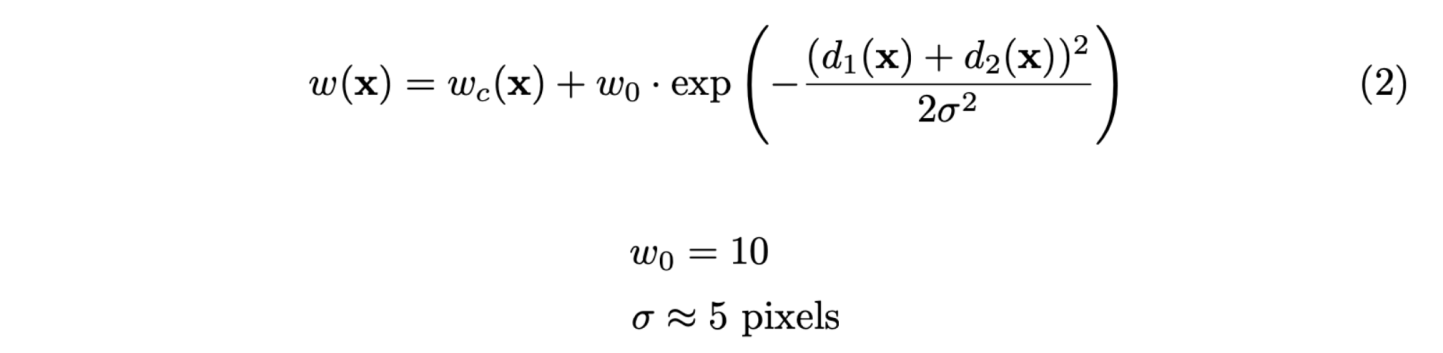

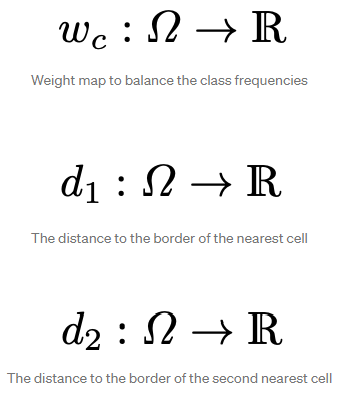

네트워크의 출력 값은 픽셀 단위의 **Softmax**로 예측된다.

즉, 최종 feature map(채널 k)에 대한 픽셀 x의 예측 값은 다음과 같이 계산된다.

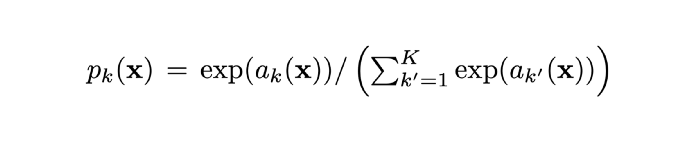

따라서 Loss Function은 **Cross-Entropy**가 사용된다. 다만, Touching Cells를 분리를 고려하기 위하여 **Weight map Loss**가 포함된다.

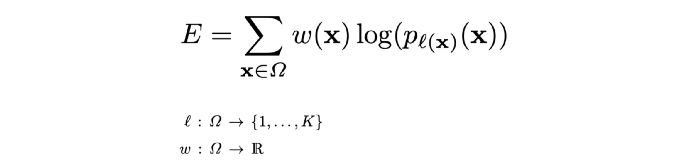

- Momentum: 0.99
- Gaussian distribution 학습 파라미터 초기화

### **Patch**

논문에서는 Sliding Window처럼 이미지를 잘라 인식하는 단위를 정했는데 그게 바로 **Patch**이다. 즉, 패치란 쉽게 설명하자면 **이미지 인식 단위**라고 생각하면 된다.

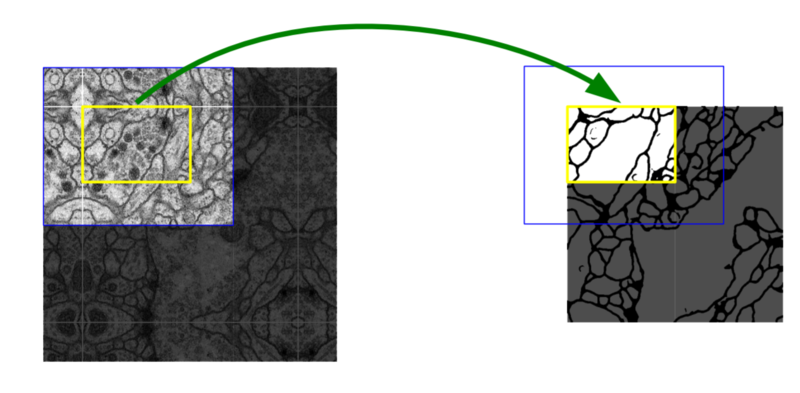

기존 sliding window 방식을 사용하면 이미 사용한 patch 구역을 다음 sliding window에서 또 검증을 하게 된다. 이에 반해 U-Net은 **검증이 끝난 부분은 아예 건너뛰고 다음 patch 부분부터 검증하기 때문에 속도를 개선**할 수 있다.

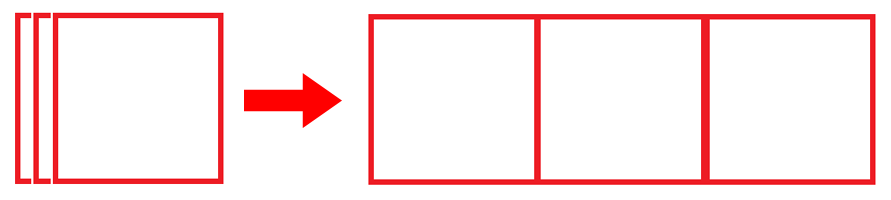

또한, **Trade off**의 높에 빠지지 않는다.

만약 Patch size가 커진다면 더 넓은 이미지를 한번에 인식하기 때문에 Context 인식에는 효과가 있다. 반면 Localization에는 패널티가 생긴다.

반면 Patch size가 작아진다면 Context 인식에는 패널티가 생기지만, Localization에는 효과가 있다.

U-Net은 **여러 Layer의 output을 동시에 검증**하면서 Localization과 Context 인식 두마리 토끼를 다 잡을 수 있다.

이처럼 다음 patch에 대한 Segmentation을 얻기 위해 이전 입력의 일부값이 포함되는 것을 **Overlap-Tite**전력이라고 한다.

### **Mirroring the input image**

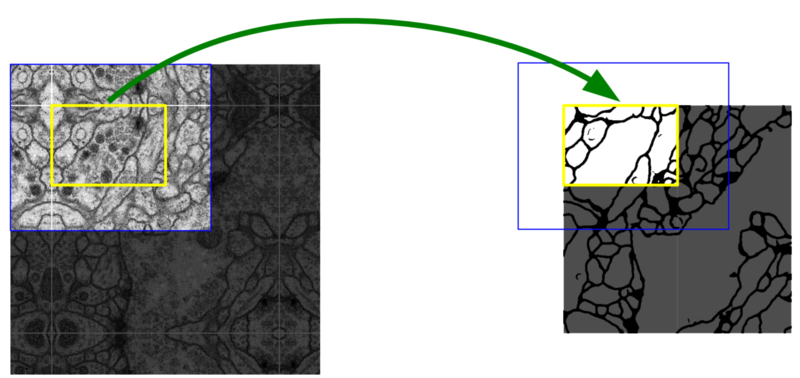

위 이미지는 input image를 U-Net에 통과시켜 나오는 output image와 사이즈 측면에서 비교한 것이다. 논문에선 input image size가 572 x 572인 반면 output image size는 388 x 388이다. 이는 **contracting path에서 padding이 없었기 때문에 외곽 이미지 부분이 없어진** 결과이다.

이를 해결하기 위하여 논문에서는 **mirroring**이라는 것을 택했다.

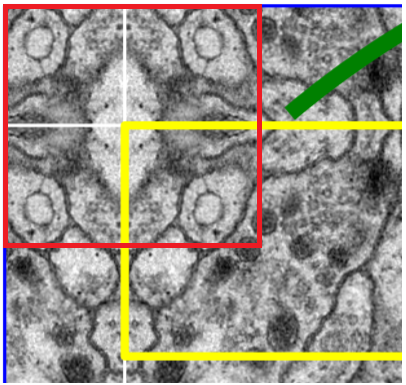

위 이미지는 input image를 확대한 것인데, 보시다 싶이 바깥쪽 없어지는 부분이 안쪽 이미지의 형태와 마치 **거울에 반사된 것**처럼 같다는걸 알 수 있다. 이처럼 사라지는 부분을 **zero-padding**이 아닌 **mirror padding**의 형태로 채워 없어진 부분에 대해 보상을 해준다.

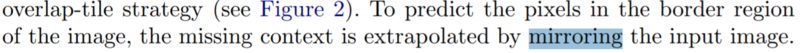

## **Data Augmentation**

training sets는 전문가만이 annotate할 수 있기 때문에 training sets가 작다. 그래서 논문에서는 training sets를 늘리기 위하여 input image 및 output segmentation map을 임의로 변형하는 **탄성 변형(Elastic Deformation)** 방식을 사용했다.

### **결론**

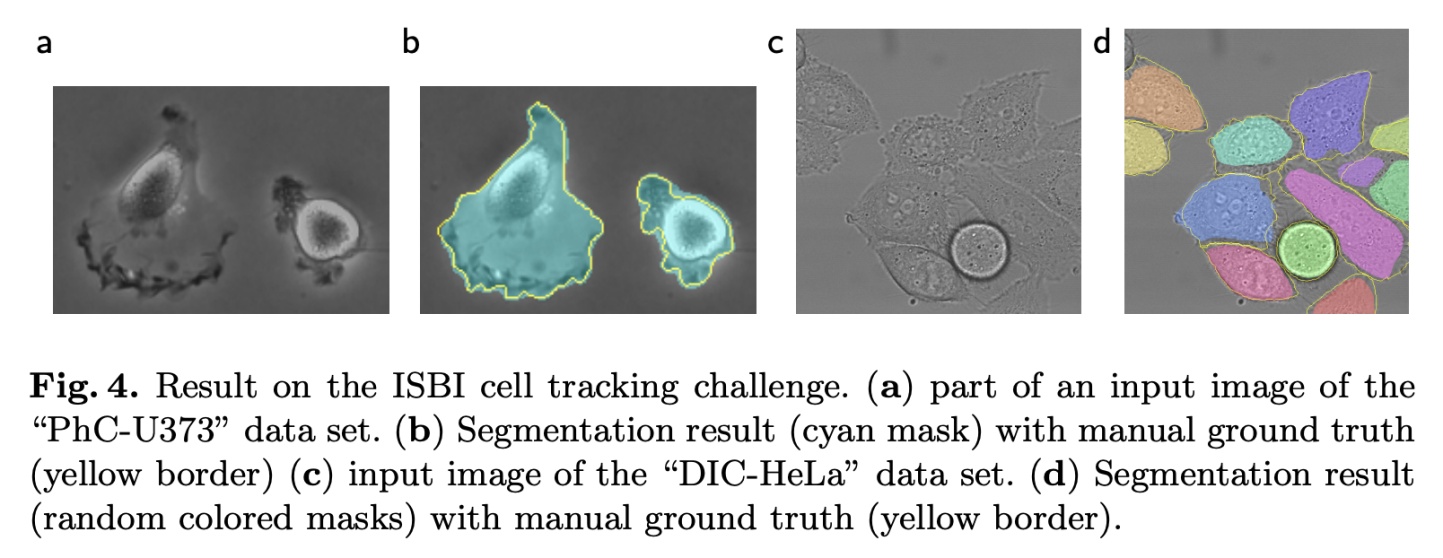

본 연구에서는, U-Net이라는 FCN보다 확장된 개념의 Up-sampling과 Skip Architecture를 적용한 모델을 제안하였다.

결과적으로 U-Net의 구조는 아주 적은 양의 학습 데이터만으로 Data Augmentation을 활용하여 여러 Biomedical Image Segmentation 문제에서 우수한 성능을 보였다.